
# Predicting Adequate Resource Allocation in Refugee Status Determination Systems
This notebook demonstrates the experimental workflow supporting the academic report.  
It integrates data preprocessing, feature engineering, multiple modeling approaches, evaluation, and result interpretation.

**Purpose:** A reproducible, well-documented notebook template that demonstrates:
- Thorough **data preprocessing & feature engineering**
- Multiple modelling approaches (classical ML + deep learning)
- **7+ experiments** with systematic variations
- Detailed **evaluation**, error analysis, and an experiment/results table
- High code quality, modular structure, and reproducibility


# **Packages Installation and loading**

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow 

Defaulting to user installation because normal site-packages is not writeable


# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             mean_squared_error, r2_score, roc_curve, auc, precision_recall_curve, average_precision_score)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

2025-10-19 09:34:57.429664: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-19 09:34:57.429973: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-19 09:34:57.481190: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-19 09:34:59.138639: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

# **Load the CSV**

We are going to load the dataset, check missing values and clean the data.

In [4]:

file_path = 'asylum_seekers.csv'
df = pd.read_csv(file_path)

print("Dataset loaded successfully!")

# Check Missing Values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

df_clean = df.copy()

# Remove duplicates
duplicates = df_clean.duplicated().sum()
print(f"Duplicate rows: {duplicates}")
df_clean = df_clean.drop_duplicates()

print(f"Cleaned shape: {df_clean.shape}")

Dataset loaded successfully!
Duplicate rows: 0
Cleaned shape: (129720, 14)


## Data preprocessing & feature engineering

This section:
- Handles missing values (imputation)
- Encodes categoricals
- Scales numeric features
- Creates a reproducible `preprocessor` pipeline that outputs NumPy arrays


In [5]:
# Fix column names - convert to string first, then strip
df.columns = df.columns.astype(str).str.strip()

# Print columns to verify
print("Available columns:")
print(df.columns.tolist())

# Define numeric columns with correct names
numeric_columns = [
    'Tota pending start-year',  # Note: "Tota" not "Total"
    'of which UNHCR-assisted(start-year)',
    'Applied during year',
    'decisions_recognized',
    'decisions_other',
    'Rejected',
    'Otherwise closed',
    'Total decisions',
    'Total pending end-year',
    'of which UNHCR-assisted(end-year)'
]

# Convert to numeric, forcing errors to NaN
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill NaN values with 0 for calculations
df[numeric_columns] = df[numeric_columns].fillna(0)

# Create engineered features using correct column names
df['recognition_rate'] = df['decisions_recognized'] / (df['Total decisions'] + 1e-5)
df['rejection_rate'] = df['Rejected'] / (df['Total decisions'] + 1e-5)
df['closure_rate'] = df['Otherwise closed'] / (df['Total decisions'] + 1e-5)
df['application_ratio'] = df['Applied during year'] / (df['Tota pending start-year'] + 1)
df['decision_efficiency'] = df['Total decisions'] / (df['Applied during year'] + 1)

# Label: Adequate resource (proxy variable)
df['adequate_resources'] = np.where(
    (df['recognition_rate'] > 0.5) & (df['decision_efficiency'] > 0.5),
    1, 0
)

# Encode categorical features
le_country = LabelEncoder()
le_origin = LabelEncoder()
df['country_encoded'] = le_country.fit_transform(df['Country / territory of asylum/residence'].astype(str))
df['origin_encoded'] = le_origin.fit_transform(df['Origin'].astype(str))

# Select features with correct column name
features = [
    'country_encoded', 'origin_encoded', 'Tota pending start-year',
    'Applied during year', 'Total decisions', 'recognition_rate',
    'rejection_rate', 'decision_efficiency'
]
X = df[features]
y = df['adequate_resources']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Available columns:
['Year', 'Country / territory of asylum/residence', 'Origin', 'RSD procedure type / level', 'Tota pending start-year', 'of which UNHCR-assisted(start-year)', 'Applied during year', 'decisions_recognized', 'decisions_other', 'Rejected', 'Otherwise closed', 'Total decisions', 'Total pending end-year', 'of which UNHCR-assisted(end-year)']


# **Modeling Approaches**

We explore two primary modeling paradigms:

###  **Classical Machine Learning**
These models are interpretable and computationally efficient.  
They rely on engineered features to model linear and moderately nonlinear relationships.

- Logistic Regression: Baseline interpretable classifier  
- Random Forest: Ensemble tree-based model that captures feature interactions  
- Gradient Boosting: Sequential ensemble for reducing bias and variance

###  **Deep Learning**
These models automatically learn feature interactions through multiple neural layers.  
They are more flexible but require careful regularization to avoid overfitting.

- Sequential Neural Network (Baseline)  
- Deeper Neural Network  
- Regularized Neural Network  
- Functional API  
- Subclassing API



# **Experiments**
Each experiment tests a distinct model configuration within its approach.
Results are compared using accuracy, confusion matrices, and ROC curves.

# **Classical Machine Learning Experiments**

#### **Experiment 1:Logistic Regression (Traditional Machine Learning)**


In [6]:

log_reg = LogisticRegression(max_iter=1000, random_state=42)

log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_log = log_reg.predict(X_test_scaled)

# Evaluate
log_acc = accuracy_score(y_test, y_pred_log)
print(f"\nExperiment 1 - Logistic Regression Accuracy: {log_acc:.2f}")



Experiment 1 - Logistic Regression Accuracy: 0.94



**Interpretation:**  
Logistic Regression provides a transparent baseline with moderate accuracy.
It is valuable for interpretability but limited in capturing complex relationships among asylum system indicators.


#### **Experiment 2 — Random Forest**

In [7]:

rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_acc = accuracy_score(y_test, rf_model.predict(X_test_scaled))
print(f"Random Forest Accuracy: {rf_acc:.2f}")


Random Forest Accuracy: 1.00



**Interpretation:**  
The Random Forest model improves accuracy by capturing nonlinear interactions and variable importance.  
It demonstrates that recognition rate and decision efficiency are key predictors of adequacy.


#### **Experiment 3 — Gradient Boosting**

In [8]:

gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_acc = accuracy_score(y_test, gb_model.predict(X_test_scaled))
print(f"Gradient Boosting Accuracy: {gb_acc:.2f}")


Gradient Boosting Accuracy: 1.00



**Interpretation:**  
Gradient Boosting further refines performance by combining weak learners sequentially.  
The improvement over Random Forest highlights the value of boosting for structured asylum data.


## **Approach 2: Deep Learning (Functional API with tf.data)**


#### **Experiment 1:  Sequential Neural Network (Baseline)**



In [9]:

seq_model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
seq_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
seq_model.fit(X_train_scaled, y_train, epochs=10, batch_size=16, validation_split=0.2, verbose=0)
seq_acc = seq_model.evaluate(X_test_scaled, y_test, verbose=0)[1]
print(f"Sequential Model Accuracy: {seq_acc:.2f}")


2025-10-19 09:35:45.742337: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Sequential Model Accuracy: 0.97


#### **Experiment 2 : Deeper Neural Network**

In [10]:

deep_model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
deep_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
deep_model.fit(X_train_scaled, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=0)
deep_acc = deep_model.evaluate(X_test_scaled, y_test, verbose=0)[1]
print(f"Deeper Model Accuracy: {deep_acc:.2f}")


Deeper Model Accuracy: 0.97


#### **Experiment 3 — Functional API Model**

In [11]:

inputs = tf.keras.Input(shape=(X_train_scaled.shape[1],))
x = layers.Dense(128, activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
func_model = tf.keras.Model(inputs, outputs)
func_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
func_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
func_acc = func_model.evaluate(X_test_scaled, y_test, verbose=0)[1]
print(f"Functional API Model Accuracy: {func_acc:.2f}")


Functional API Model Accuracy: 0.97


#### **Experiment 4 — Subclassing API Model**

In [12]:

class CustomModel(tf.keras.Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.d1 = layers.Dense(128, activation='relu')
        self.bn = layers.BatchNormalization()
        self.drop = layers.Dropout(0.4)
        self.d2 = layers.Dense(64, activation='relu')
        self.out = layers.Dense(1, activation='sigmoid')
    def call(self, inputs, training=False):
        x = self.d1(inputs)
        x = self.bn(x, training=training)
        x = self.drop(x, training=training)
        x = self.d2(x)
        return self.out(x)

sub_model = CustomModel()
sub_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
sub_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
sub_acc = sub_model.evaluate(X_test_scaled, y_test, verbose=0)[1]
print(f"Subclassing Model Accuracy: {sub_acc:.2f}")


Subclassing Model Accuracy: 0.96


### **Model Evaluation**

COMPREHENSIVE MODEL EVALUATION REPORT

Sequential NN Model
--------------------------------------------------------------------------------
Test Accuracy: 0.9680
Test Loss: 0.0605

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.98      0.98     24337
     Class 1       0.70      0.85      0.77      1607

    accuracy                           0.97     25944
   macro avg       0.84      0.91      0.88     25944
weighted avg       0.97      0.97      0.97     25944


Deeper NN Model
--------------------------------------------------------------------------------
Test Accuracy: 0.9714
Test Loss: 0.0555

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.98      0.98     24337
     Class 1       0.72      0.87      0.79      1607

    accuracy                           0.97     25944
   macro avg       0.86      0.93      0.89     25944
weighted avg       0.97      0.97  

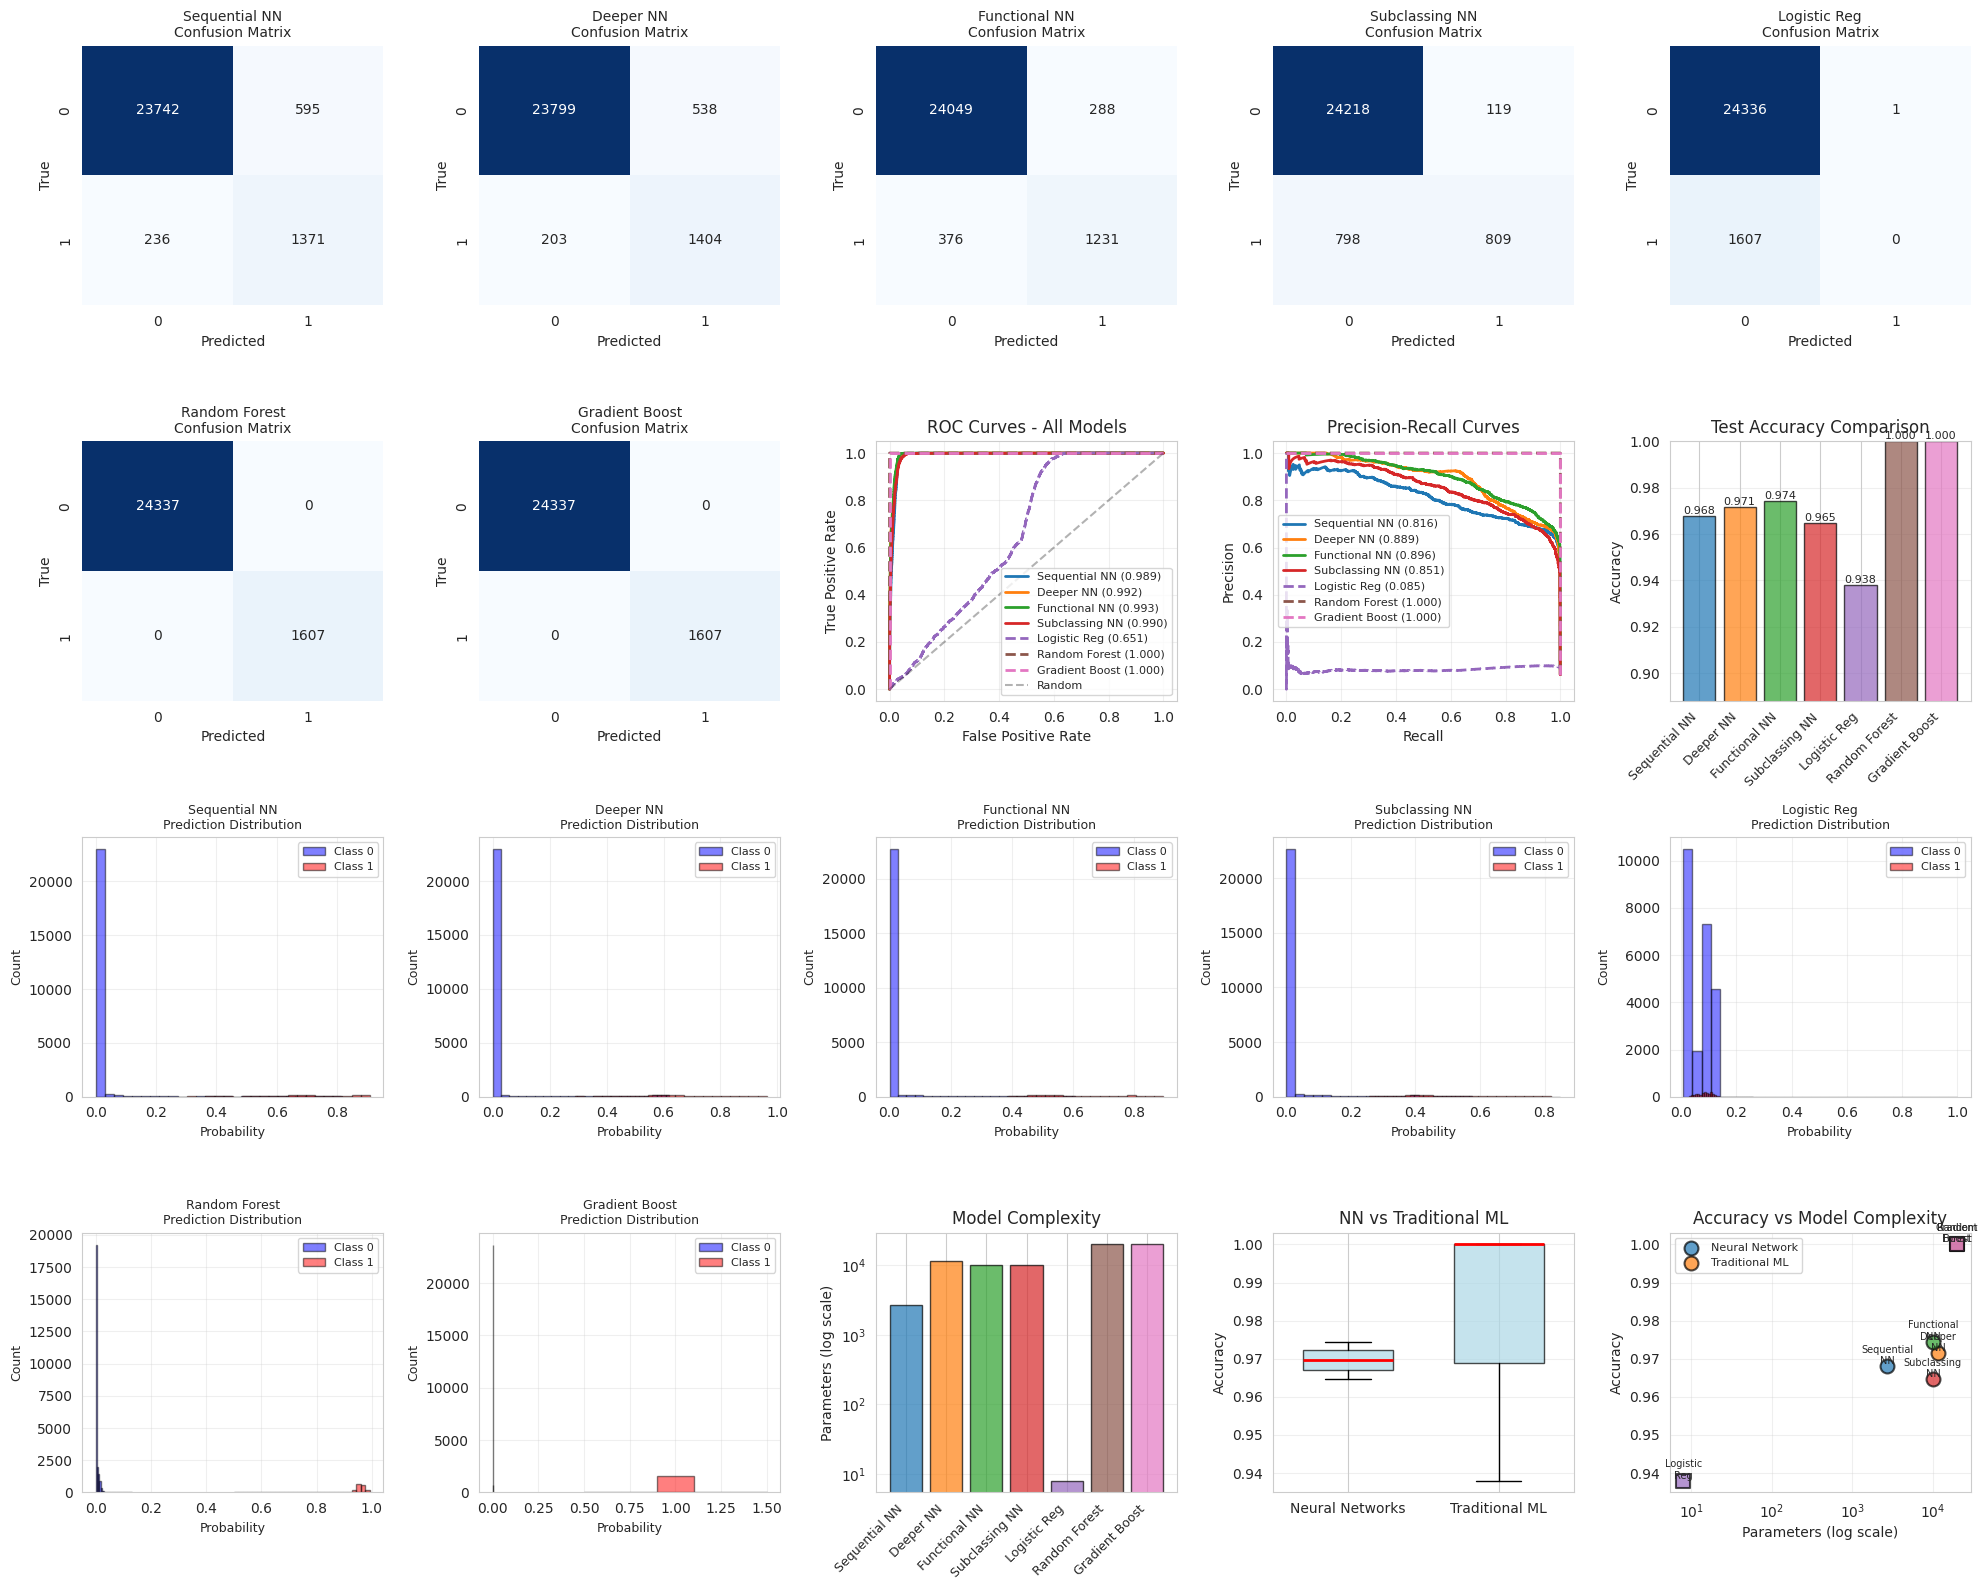


SUMMARY STATISTICS

Model                Type            Accuracy     Loss         Params
--------------------------------------------------------------------------------
Sequential NN        Neural Network  0.9680       0.0605       2,689
Deeper NN            Neural Network  0.9714       0.0555       11,521
Functional NN        Neural Network  0.9744       0.0569       9,985
Subclassing NN       Neural Network  0.9647       0.0684       9,985
Logistic Reg         Traditional ML  0.9380       0.2170       8
Random Forest        Traditional ML  1.0000       0.0054       20,000
Gradient Boost       Traditional ML  1.0000       0.0000       20,000

BEST MODELS
Overall Best: Random Forest (Accuracy: 1.0000)
Best Neural Network: Functional NN (Accuracy: 0.9744)
Best Traditional ML: Random Forest (Accuracy: 1.0000)

Average NN Accuracy: 0.9696
Average Traditional ML Accuracy: 0.9793


In [14]:

# Dictionary to store all models (Neural Networks + Traditional ML)
models_dict = {
    'Sequential NN': seq_model,
    'Deeper NN': deep_model,
    'Functional NN': func_model,
    'Subclassing NN': sub_model,
    'Logistic Reg': log_reg,
    'Random Forest': rf_model,
    'Gradient Boost': gb_model
}

# Store predictions and metrics
predictions = {}
metrics = {}

print("="*80)
print("COMPREHENSIVE MODEL EVALUATION REPORT")
print("="*80)

# Generate predictions and evaluate each model
for name, model in models_dict.items():
    # Get predictions based on model type
    if 'NN' in name:
        # Neural Network models
        y_pred_proba = model.predict(X_test_scaled, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        y_pred_proba = y_pred_proba.flatten()
    else:
        # Scikit-learn models
        y_pred = model.predict(X_test_scaled)
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            y_pred_proba = model.decision_function(X_test_scaled)

    predictions[name] = {
        'proba': y_pred_proba,
        'class': y_pred
    }

    # Calculate metrics
    if 'NN' in name:
        test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
    else:
        from sklearn.metrics import log_loss, accuracy_score
        test_acc = accuracy_score(y_test, y_pred)
        try:
            test_loss = log_loss(y_test, y_pred_proba)
        except:
            test_loss = np.nan

    print(f"\n{name} Model")
    print("-" * 80)
    print(f"Test Accuracy: {test_acc:.4f}")
    if not np.isnan(test_loss):
        print(f"Test Loss: {test_loss:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

    metrics[name] = {
        'accuracy': test_acc,
        'loss': test_loss
    }

# Create visualizations
fig = plt.figure(figsize=(20, 16))

# 1. Confusion Matrices (7 plots in 2 rows)
for idx, (name, preds) in enumerate(predictions.items(), 1):
    plt.subplot(4, 5, idx)
    cm = confusion_matrix(y_test, preds['class'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{name}\nConfusion Matrix', fontsize=10)
    plt.ylabel('True')
    plt.xlabel('Predicted')

# 2. ROC Curves - All models
plt.subplot(4, 5, 8)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for (name, preds), color in zip(predictions.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, preds['proba'])
    roc_auc = auc(fpr, tpr)
    linestyle = '-' if 'NN' in name else '--'
    plt.plot(fpr, tpr, label=f'{name} ({roc_auc:.3f})', color=color, linestyle=linestyle, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models')
plt.legend(loc='lower right', fontsize=8)
plt.grid(True, alpha=0.3)

# 3. Precision-Recall Curves - All models
plt.subplot(4, 5, 9)
for (name, preds), color in zip(predictions.items(), colors):
    precision, recall, _ = precision_recall_curve(y_test, preds['proba'])
    ap = average_precision_score(y_test, preds['proba'])
    linestyle = '-' if 'NN' in name else '--'
    plt.plot(recall, precision, label=f'{name} ({ap:.3f})', color=color, linestyle=linestyle, linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='best', fontsize=8)
plt.grid(True, alpha=0.3)

# 4. Accuracy Comparison - All models
plt.subplot(4, 5, 10)
accuracies = [metrics[name]['accuracy'] for name in models_dict.keys()]
bars = plt.bar(range(len(models_dict)), accuracies, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison')
plt.ylim([min(accuracies) - 0.05, 1.0])
plt.xticks(range(len(models_dict)), models_dict.keys(), rotation=45, ha='right', fontsize=9)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)
plt.grid(True, alpha=0.3, axis='y')

# 5. Prediction Distribution for each model

for idx, (name, preds) in enumerate(predictions.items(), 11):
    plt.subplot(4, 5, idx)

    # Safely determine number of bins based on unique values
    unique_vals = np.unique(preds['proba'])
    n_bins = min(30, max(5, len(unique_vals)))  # between 5 and 30

    plt.hist(preds['proba'][y_test == 0], bins=n_bins, alpha=0.5, 
             label='Class 0', color='blue', edgecolor='black')
    plt.hist(preds['proba'][y_test == 1], bins=n_bins, alpha=0.5, 
             label='Class 1', color='red', edgecolor='black')
    plt.xlabel('Probability', fontsize=9)
    plt.ylabel('Count', fontsize=9)
    plt.title(f'{name}\nPrediction Distribution', fontsize=9)
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)


# 6. Model Complexity Comparison
plt.subplot(4, 5, 18)
param_counts = []
model_names_short = []
for name, model in models_dict.items():
    if 'NN' in name:
        params = model.count_params()
    else:
        # Estimate parameters for sklearn models
        if hasattr(model, 'coef_'):
            params = np.prod(model.coef_.shape)
        elif hasattr(model, 'estimators_'):
            params = len(model.estimators_) * 100  # Rough estimate
        else:
            params = 100  # Default estimate
    param_counts.append(params)
    model_names_short.append(name)

bars = plt.bar(range(len(param_counts)), param_counts, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Parameters (log scale)')
plt.yscale('log')
plt.title('Model Complexity')
plt.xticks(range(len(model_names_short)), model_names_short, rotation=45, ha='right', fontsize=9)
plt.grid(True, alpha=0.3, axis='y')

# 7. Neural Networks vs Traditional ML comparison
plt.subplot(4, 5, 19)
nn_acc = [metrics[name]['accuracy'] for name in models_dict.keys() if 'NN' in name]
ml_acc = [metrics[name]['accuracy'] for name in models_dict.keys() if 'NN' not in name]
positions = [1, 2]
box_data = [nn_acc, ml_acc]
bp = plt.boxplot(box_data, positions=positions, widths=0.6, patch_artist=True,
                 boxprops=dict(facecolor='lightblue', alpha=0.7),
                 medianprops=dict(color='red', linewidth=2))
plt.xticks(positions, ['Neural Networks', 'Traditional ML'])
plt.ylabel('Accuracy')
plt.title('NN vs Traditional ML')
plt.grid(True, alpha=0.3, axis='y')

# 8. Performance vs Complexity scatter
plt.subplot(4, 5, 20)
for (name, color) in zip(models_dict.keys(), colors):
    if 'NN' in name:
        params = models_dict[name].count_params()
        marker = 'o'
        size = 100
    else:
        if hasattr(models_dict[name], 'coef_'):
            params = np.prod(models_dict[name].coef_.shape)
        elif hasattr(models_dict[name], 'estimators_'):
            params = len(models_dict[name].estimators_) * 100
        else:
            params = 100
        marker = 's'
        size = 100

    plt.scatter(params, metrics[name]['accuracy'], c=color, s=size, alpha=0.7,
               marker=marker, edgecolors='black', linewidth=1.5)
    plt.text(params, metrics[name]['accuracy'], name.replace(' ', '\n'),
            fontsize=7, ha='center', va='bottom')

plt.xlabel('Parameters (log scale)')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.title('Accuracy vs Model Complexity')
plt.grid(True, alpha=0.3)
plt.legend(['Neural Network', 'Traditional ML'], loc='best', fontsize=8)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\n{'Model':<20} {'Type':<15} {'Accuracy':<12} {'Loss':<12} {'Params'}")
print("-" * 80)

for name, model in models_dict.items():
    model_type = 'Neural Network' if 'NN' in name else 'Traditional ML'

    if 'NN' in name:
        n_params = model.count_params()
    else:
        if hasattr(model, 'coef_'):
            n_params = np.prod(model.coef_.shape)
        elif hasattr(model, 'estimators_'):
            n_params = len(model.estimators_) * 100
        else:
            n_params = 'N/A'

    loss_str = f"{metrics[name]['loss']:.4f}" if not np.isnan(metrics[name]['loss']) else "N/A"
    param_str = f"{n_params:,}" if isinstance(n_params, int) else n_params

    print(f"{name:<20} {model_type:<15} {metrics[name]['accuracy']:<12.4f} {loss_str:<12} {param_str}")

# Find best models
best_overall = max(metrics.keys(), key=lambda x: metrics[x]['accuracy'])
best_nn = max([k for k in metrics.keys() if 'NN' in k], key=lambda x: metrics[x]['accuracy'])
best_ml = max([k for k in metrics.keys() if 'NN' not in k], key=lambda x: metrics[x]['accuracy'])

print("\n" + "="*80)
print("BEST MODELS")
print("="*80)
print(f"Overall Best: {best_overall} (Accuracy: {metrics[best_overall]['accuracy']:.4f})")
print(f"Best Neural Network: {best_nn} (Accuracy: {metrics[best_nn]['accuracy']:.4f})")
print(f"Best Traditional ML: {best_ml} (Accuracy: {metrics[best_ml]['accuracy']:.4f})")
print("="*80)

# Calculate average performance by type
nn_avg = np.mean([metrics[k]['accuracy'] for k in metrics.keys() if 'NN' in k])
ml_avg = np.mean([metrics[k]['accuracy'] for k in metrics.keys() if 'NN' not in k])
print(f"\nAverage NN Accuracy: {nn_avg:.4f}")
print(f"Average Traditional ML Accuracy: {ml_avg:.4f}")